<a href="https://colab.research.google.com/github/Existanze54/sirius-machine-learning-2024/blob/main/Seminars/Solutions/S8s_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Основные методы ML

### Семинар 8: Деревья решений и случайный лес

Максимальная глубина, связь с variance. Bagging деревьев. One-hot кодирование. Оптимизация параметров GridSearchCV

In [ ]:
import scipy
import numpy as np
import pandas as pd

import itertools
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import matthews_corrcoef

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import KFold, GridSearchCV, train_test_split

### Задача 1: Bias-variance trade-off


Продемонстрируйте bias-variance trade-off на примере DecisionTreeRegressor на представленном датасете, используя функцию plot_regression_predictions и приведенный ниже код (можете модифицировать).

*Подсказка*: попробуйте несколько значений глубины *max_depth* в пределах от 2 до 10 и сравните с дефолтным None. Также можете попробовать варьировать другие параметры.

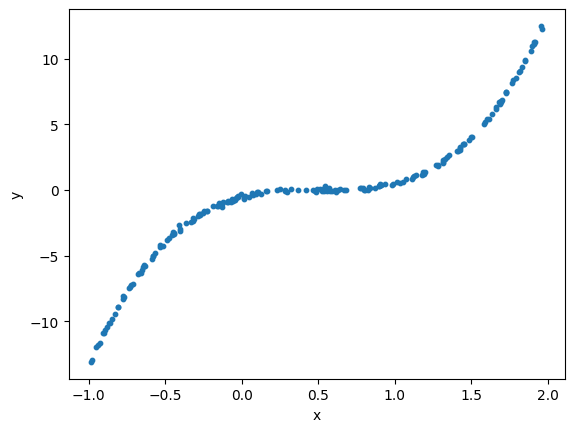

In [ ]:
np.random.seed(42)
m = 200
X = np.random.rand(m, 1) * 3 - 1
y = 4 * (X - 0.5) ** 3
y = y + np.random.randn(m, 1) / 10

plt.scatter(X,y,s=10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
def plot_regression_predictions(tree_reg, X, y, ax, limits=[0, 1, -1, 1], title=""):
    """Передайте обученное дерево, координаты кривой Х и y,
        объект ax для отрисовки, опционально - координаты границ
         и заголовок графика"""
    x1 = np.linspace(limits[0], limits[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    ax.axis(limits)
    ax.set_title(title)
    ax.plot(X, y, "b.")
    ax.plot(x1, y_pred, "r.-", alpha=0.1, linewidth=1, label="y")

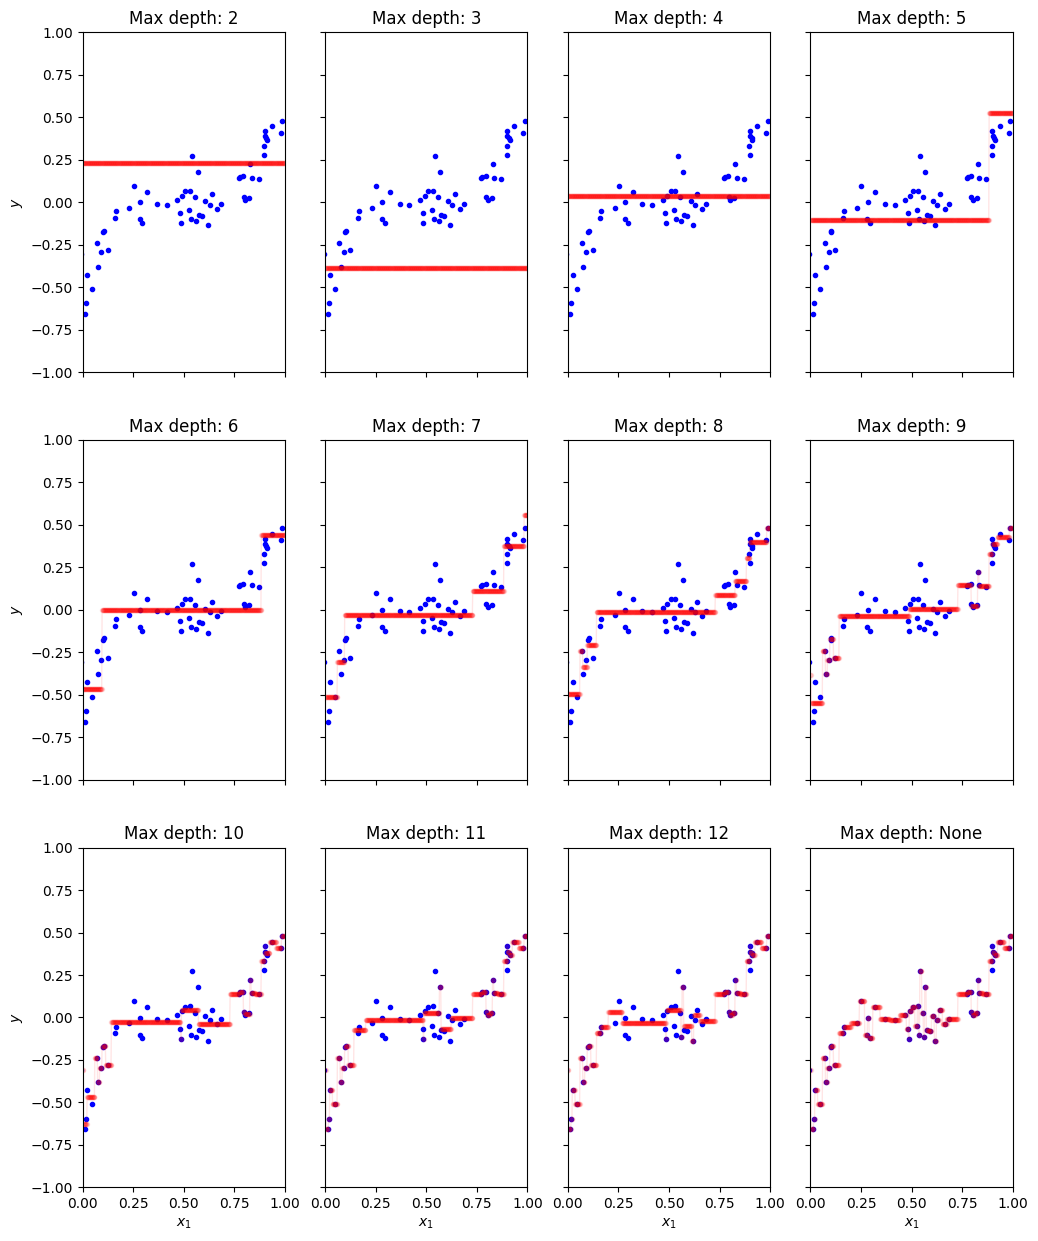

In [ ]:
fig, axes = plt.subplots(3,4, figsize=(12,15))
axes = axes.flat

for i, d in enumerate(list(range(2,13))+ [None]):
    axes[i].set(xlabel="$x_1$", ylabel="$y$")
    axes[i].label_outer()
    model = DecisionTreeRegressor(max_depth=d).fit(X, y)
    plot_regression_predictions(model, X, y, axes[i], limits=[0, 1, -1, 1], title=f"Max depth: {d}")

### Задача 2: Качество Bagging с различными базовыми моделями

Попробуем оценить эффект бэггинга на качестве различных моделей классификации: логистической регрессии, SVC и дерева решений.

На датасете *breast_cancer* обучите модели Decision Tree, SVC (с параметрами по умолчанию) и логистическую регрессию.

Полученные предсказания на тесте оцените при помощи корреляции мэтьюса (**sklearn.metrics.matthews_corrcoef**, почитать про пользу этой метрики можно [здесь](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7)), построив 90% доверительные интервалы при помощи реализующей bootstrap функции *bootstrap_metric*. Результат отобразите в виде боксплотов.

Обучите **BaggingClassifier** (предварительно почитав [документацию](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)) с теми же самыми моделями в качестве базового эстиматора и числом эстиматоров равным 100.

На новом графике отобразите боксплоты для всех 6 моделей. Сделайте выводы.

In [ ]:
from sklearn.datasets import load_breast_cancer

def bootstrap_metric(x, y,
                    metric_fn,
                    samples_cnt=1000,
                    random_state=777):
    size = len(x)
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)
    for it in range(samples_cnt):
        poses = np.random.choice(x.shape[0], size=x.shape[0], replace=True)

        x_boot = x[poses]
        y_boot = y[poses]

        m_val = metric_fn(x_boot, y_boot)
        b_metric[it] = m_val

    return b_metric

In [ ]:
breast_cancer = load_breast_cancer()
#print(breast_cancer.DESCR)

In [ ]:
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=777)

Обучите базовые модели и сравните качество:

In [ ]:
logr_model = LogisticRegression(solver='liblinear',\
                                max_iter=1000).fit(X_train, y_train)

dt_model = DecisionTreeClassifier().fit(X_train, y_train)

svc_model = SVC().fit(X_train, y_train)

In [ ]:
logr_pred  =   logr_model.predict(X_test)
dt_pred    =   dt_model.predict(X_test)
svc_pred   =   svc_model.predict(X_test)

In [ ]:
boot_score_dt = bootstrap_metric(y_test,
                                   dt_pred,
                                   metric_fn=lambda x, y: matthews_corrcoef(y_true=x,
                                                                                  y_pred=y))
boot_score_svc = bootstrap_metric(y_test,
                                   svc_pred,
                                   metric_fn=lambda x, y: matthews_corrcoef(y_true=x,
                                                                                  y_pred=y))
boot_score_logr = bootstrap_metric(y_test,
                                   logr_pred,
                                   metric_fn=lambda x, y: matthews_corrcoef(y_true=x,
                                                                                  y_pred=y))

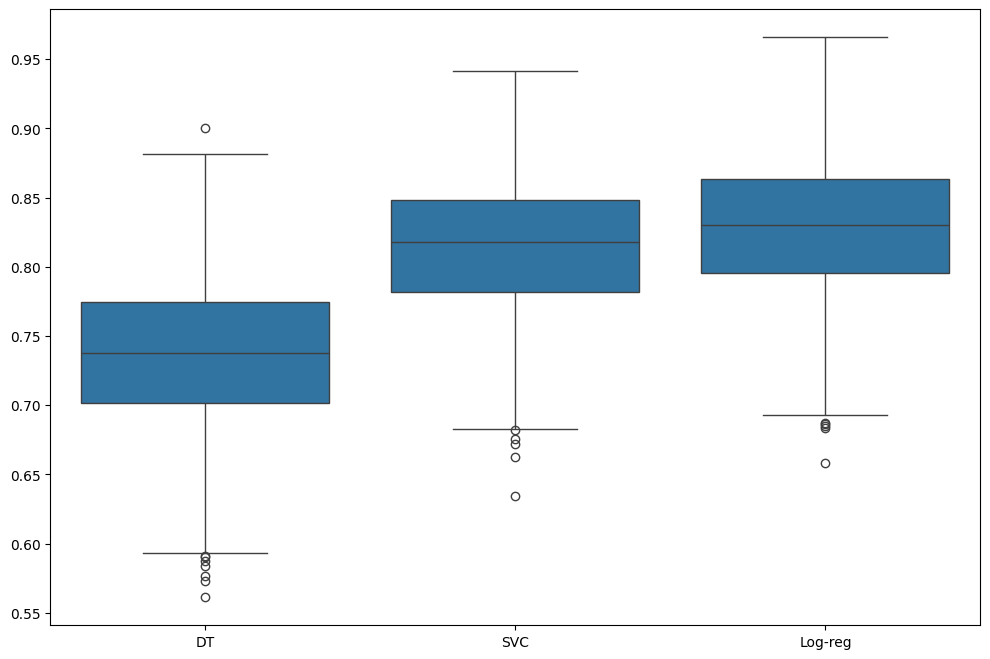

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(y=np.concatenate([boot_score_dt,
                              boot_score_svc,
                              boot_score_logr]),
             x=["DT"] * 1000 + ['SVC'] * 1000 + ['Log-reg'] * 1000 )
plt.show();

Создайте ансамбли BaggingClassifier с рассмотренными выше моделями в качестве базовых эстиматоров и числом эстиматоров равным 100. Получите для каждого из них предсказание и bootstrap-оценку. Добавьте полученные данные на график.

In [ ]:

bagged_svc_model = BaggingClassifier(SVC(), \
                                     n_estimators=100).fit(X_train, y_train)
bagged_dt_model = BaggingClassifier(DecisionTreeClassifier(), \
                                     n_estimators=100).fit(X_train, y_train)
bagged_logr_model = BaggingClassifier(LogisticRegression(solver='liblinear',\
                                max_iter=1000), \
                                     n_estimators=100).fit(X_train, y_train)


In [ ]:
b_logr_pred  =   bagged_logr_model.predict(X_test)
b_dt_pred    =   bagged_dt_model.predict(X_test)
b_svc_pred   =   bagged_svc_model.predict(X_test)

In [ ]:
matthews_m = lambda x, y: matthews_corrcoef(y_true=x, y_pred=y)

b_boot_score_dt = bootstrap_metric(y_test, b_dt_pred, metric_fn=matthews_m)
b_boot_score_svc = bootstrap_metric(y_test, b_svc_pred, metric_fn=matthews_m)
b_boot_score_logr = bootstrap_metric(y_test, b_logr_pred , metric_fn=matthews_m)

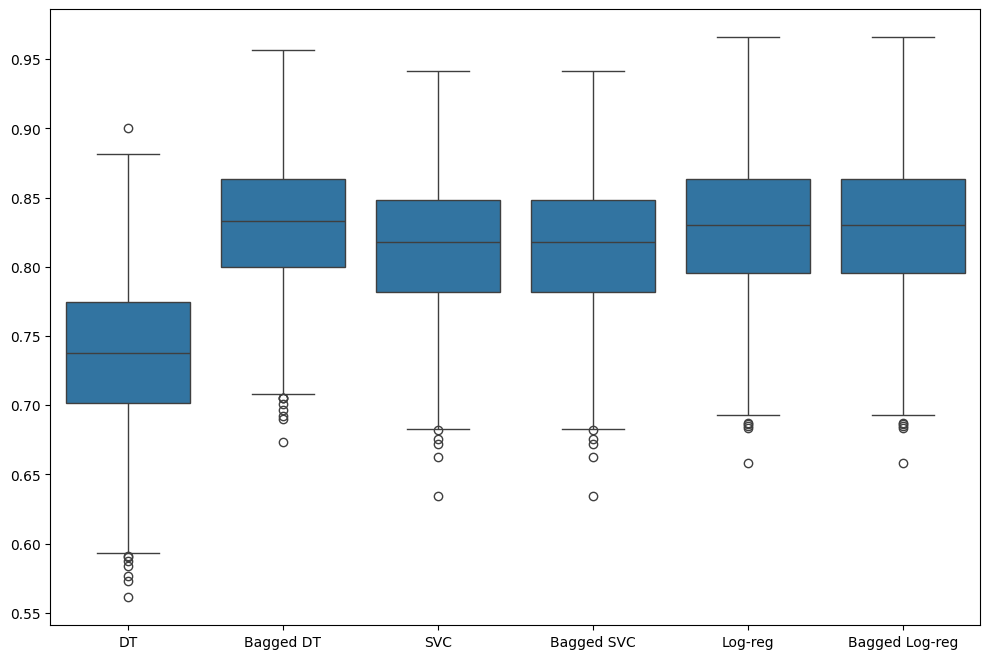

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(y=np.concatenate([boot_score_dt,
                              b_boot_score_dt,
                              boot_score_svc,
                              b_boot_score_svc,
                              boot_score_logr,
                              b_boot_score_logr]),
             x=["DT"] * 1000 + ["Bagged DT"] * 1000 + ['SVC'] * 1000 \
             + ['Bagged SVC'] * 1000 + ['Log-reg'] * 1000 + ['Bagged Log-reg'] * 1000)
plt.show()

### Задача 3: Древесные модели и работа с признаками.

Поработаем с  [датасетом](https://www.kaggle.com/ronitf/heart-disease-uci), содержащим признаковые описания здоровых людей и пациентов с заболеваниями сердца.

In [ ]:
!wget https://data.bioml.ru/htdocs/courses/python/datasci/pandas/data/heart_uci_cleveland.csv -O heart.csv

--2024-11-20 04:46:51--  https://data.bioml.ru/htdocs/courses/python/datasci/pandas/data/heart_uci_cleveland.csv
Resolving data.bioml.ru (data.bioml.ru)... 188.120.231.217
Connecting to data.bioml.ru (data.bioml.ru)|188.120.231.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11106 (11K) [text/csv]
Saving to: ‘heart.csv’

heart.csv           100%[===================>]  10.85K  --.-KB/s    in 0s      

2024-11-20 04:46:53 (163 MB/s) - ‘heart.csv’ saved [11106/11106]



In [ ]:
heart_dataset = pd.read_csv("heart.csv")
print(heart_dataset.shape)
print(heart_dataset.columns.values)
X = heart_dataset.drop("condition", axis=1)
y = heart_dataset['condition'] > 0
X_train, X_test, y_train, y_test = train_test_split(X, y.values, random_state=777)

(297, 14)
['age' 'sex' 'cp' 'trestbps' 'chol' 'fbs' 'restecg' 'thalach' 'exang'
 'oldpeak' 'slope' 'ca' 'thal' 'condition']


In [ ]:
heart_dataset

NameError: name 'heart_dataset' is not defined

#### Эксперимент: обучение классификаторов на вещественных признаках

Качество алгоритмов может зависеть не только от значений гиперпараметров, но и от предобратки исходных признаков. Некоторые из рассмотренных нами алгоритмов чувствительны к масштабу признаков. Посмотрим, насколько различны распределения признаков. Постройте гистограммы для признаков 'age', 'trestbps', 'chol', 'thalach', 'oldpeak'.

Глядя на получившиеся графики, скажите в чем заключается особенность данных? На какие алгоритмы это может повлиять? Почему?

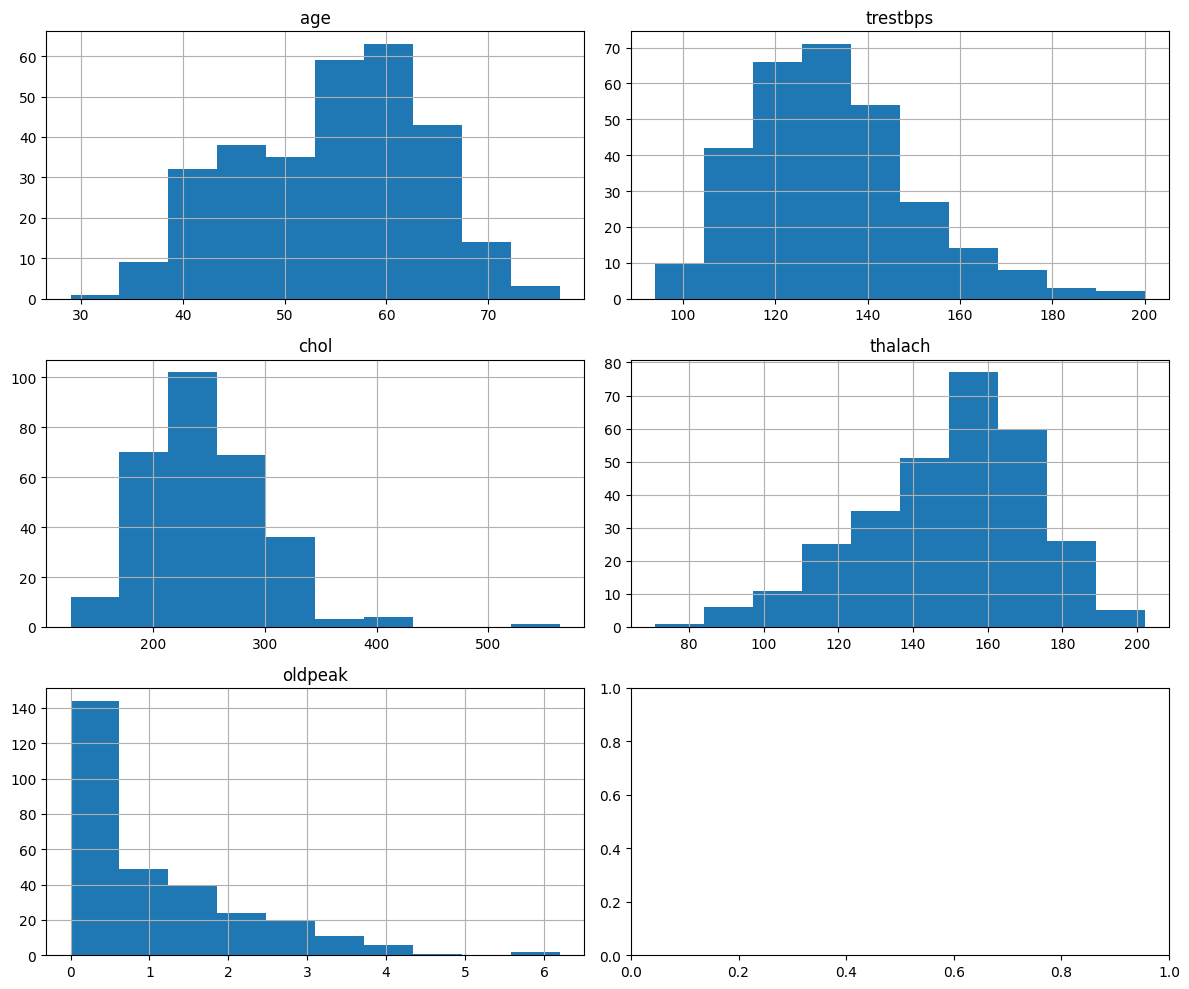

In [ ]:
fig, axes = plt.subplots(3,2, figsize=(12,10))
axes = axes.flat
for i, name in enumerate(['age', 'trestbps', 'chol', 'thalach', 'oldpeak']):
    heart_dataset[name].hist(ax=axes[i])
    axes[i].set_title(name)
fig.tight_layout()

Масштабирование признаков можно выполнить, например, одним из следующих способов:

$x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке;

$x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ —  интервал наблюдаемых значений признака.

Такие схемы масштабирования приведены в классах [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) и [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler).

Отберите все вещественные признаки и масштабируйте их одним из указанных способов.




In [ ]:
real_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
X_train_real = X_train[real_features]
X_test_real = X_test[real_features]

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_real_scaled = scaler.fit_transform(X_train_real)
X_test_real_scaled = scaler.transform(X_test_real)

В этой задаче будем рассматривать алгоритм *RandomForestClassifier*.

Для начала оцените среднее и std качества работы алгоритма с параметрами по умолчанию на масштабированных и исходных вещественных признаках из тренировочной выборки при помощи функции [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). По умолчанию она оценивает качество работы модели по 5 фолдам.


Сделайте вывод о необходимости масштабировать признаки перед подачей их в древесные модели.

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(estimator=RandomForestClassifier(), X=X_train_real, y=y_train)

array([0.8       , 0.62222222, 0.70454545, 0.68181818, 0.68181818])

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(estimator=RandomForestClassifier(), X=X_train_real_scaled, y=y_train)

array([0.71111111, 0.64444444, 0.72727273, 0.75      , 0.68181818])

#### Добавление категориальных признаков в модель

Вспомним, что у нас еще есть категориальные признаки. Случайный лес умеет работать с ними напрямую в том виде, в котором они в датасете находятся сейчас, однако многие другие модели требуют дополнительной предобработки.

Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)). Передайте в функцию список колонок, которые необходимо закодировать.

После кодирования признаков разбейте датасет заново на тренировочную и тестовую выборки тем же способом, что и раньше.

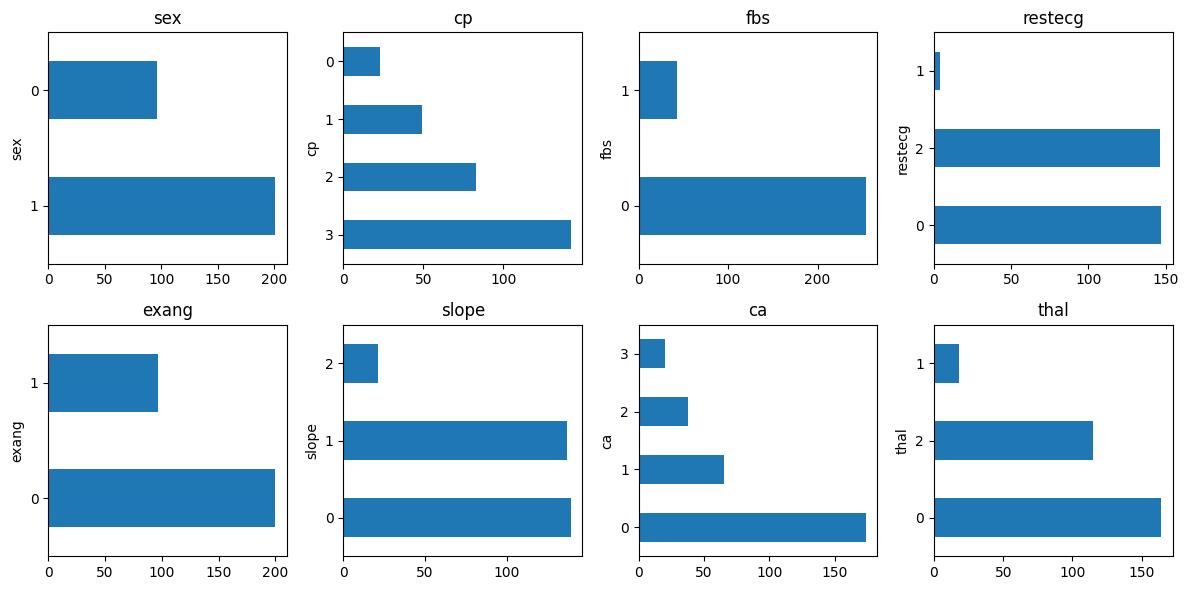

In [ ]:
cat_columns = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]

plt.figure(figsize=(12, 6))
for i, col in enumerate(cat_columns, 1):
    plt.subplot(2, 4, i)
    heart_dataset[col].value_counts().plot.barh()
    plt.title(col)
plt.tight_layout()

In [ ]:
heart_dataset_transformed = pd.get_dummies(heart_dataset, columns = ["cp", "restecg", "slope", "ca", "thal"])
heart_dataset_transformed

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,condition,cp_0,...,slope_0,slope_1,slope_2,ca_0,ca_1,ca_2,ca_3,thal_0,thal_1,thal_2
0,69,1,160,234,1,131,0,0.1,0,True,...,False,True,False,False,True,False,False,True,False,False
1,69,0,140,239,0,151,0,1.8,0,True,...,True,False,False,False,False,True,False,True,False,False
2,66,0,150,226,0,114,0,2.6,0,True,...,False,False,True,True,False,False,False,True,False,False
3,65,1,138,282,1,174,0,1.4,1,True,...,False,True,False,False,True,False,False,True,False,False
4,64,1,110,211,0,144,1,1.8,0,True,...,False,True,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,40,1,152,223,0,181,0,0.0,1,False,...,True,False,False,True,False,False,False,False,False,True
293,39,1,118,219,0,140,0,1.2,1,False,...,False,True,False,True,False,False,False,False,False,True
294,35,1,120,198,0,130,1,1.6,1,False,...,False,True,False,True,False,False,False,False,False,True
295,35,0,138,183,0,182,0,1.4,0,False,...,True,False,False,True,False,False,False,True,False,False


Обучим случайный лес.

Подберите для него оптимальные значения гиперпараметров, а именно параметр глубины (*max_depth*), критерий разбиения в деревьях (*criterion*) и максимальное число признаков *max_features*.

Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Для ускорения вычислений можете передать параметр *n_jobs = -1*.

Обратите внимание, что эта операция может быть ресурсо- и трудоемкой! Не используйте большие массивы перебираемых значений параметров.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [ ]:
params = {
    "n_estimators": [1, 10, 100],
    "max_depth": [2, 5, 7, 10, 15, None],
    "criterion": ["gini", "entropy"],
    "max_features": ["sqrt", "log2", None]
}

grid = GridSearchCV(RandomForestClassifier(), params, verbose=3, n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 5, 7, 10, 15, None],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [1, 10, 100]},
             verbose=3)

In [ ]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 2,
 'max_features': 'sqrt',
 'n_estimators': 100}

Оцените качество предсказания обученной на всех признаках модели на тесте. Используйте classification_report.

In [ ]:
rf = RandomForestClassifier(**grid.best_params_)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=2)

In [ ]:
y_pred = rf.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.85      0.93      0.89        42
        True       0.90      0.79      0.84        33

    accuracy                           0.87        75
   macro avg       0.87      0.86      0.86        75
weighted avg       0.87      0.87      0.87        75



In [ ]:
rf = RandomForestClassifier(max_depth=None, criterion="gini", max_features=None)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.78      0.86      0.82        42
        True       0.79      0.70      0.74        33

    accuracy                           0.79        75
   macro avg       0.79      0.78      0.78        75
weighted avg       0.79      0.79      0.78        75

